In [6]:
import pandas as pd
from fastai.vision.all import *
import os
import random

# Load CSV files
train_df = pd.read_csv('rsna-2024-lumbar-spine-degenerative-classification/train.csv')
train_label_df = pd.read_csv('rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')
train_series_df = pd.read_csv('rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')

# train_df.head()

# Split by study ID
unique_studies = train_df['study_id'].unique()
random.shuffle(unique_studies)
train_studies = unique_studies[:int(0.8 * len(unique_studies))]
valid_studies = unique_studies[int(0.8 * len(unique_studies)):]

# Assign is_valid flag based on the split
train_df['is_valid'] = train_df['study_id'].apply(lambda x: x in valid_studies)

# View the dataset structure
train_df.head()


,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1,is_valid
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,False
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild,False
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,False
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,False
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,False


Train Studies: 1580, Validation Studies: 395


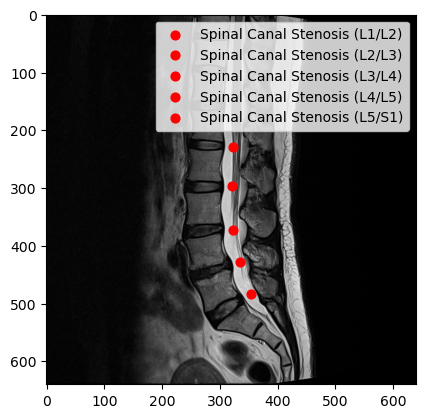

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from fastai.vision.all import *
import pydicom
import os
import numpy as np
import matplotlib.pyplot as plt

# Load CSV files
train_df = pd.read_csv('rsna-2024-lumbar-spine-degenerative-classification/train.csv')
label_coords = pd.read_csv('rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')

# Split the dataset by study_id
train_studies, valid_studies = train_test_split(train_df['study_id'].unique(), test_size=0.2, random_state=42)

# Split the main DataFrame
train_df = train_df[train_df['study_id'].isin(train_studies)]
valid_df = train_df[train_df['study_id'].isin(valid_studies)]

# Verify splitting by unique study IDs
print(f"Train Studies: {len(train_studies)}, Validation Studies: {len(valid_studies)}")

# Define image loading function using pydicom
def load_dicom_image(study_id, series_id, instance_number):
    dicom_path = f'rsna-2024-lumbar-spine-degenerative-classification/train_images/{study_id}/{series_id}/{instance_number}.dcm'
    dicom = pydicom.dcmread(dicom_path)
    img = dicom.pixel_array.astype(np.float32)
    img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize the pixel values
    return img

# Visualization of an image and annotations
def plot_image_with_annotations(study_id, series_id, instance_number, df):
    img = load_dicom_image(study_id, series_id, instance_number)
    plt.imshow(img, cmap='gray')
    
    annotations = df[(df['study_id'] == study_id) & 
                     (df['series_id'] == series_id) & 
                     (df['instance_number'] == instance_number)]
    
    for _, row in annotations.iterrows():
        plt.scatter(row['x'], row['y'], label=f"{row['condition']} ({row['level']})", color='red', s=40)
    
    plt.legend(loc="upper right")
    plt.show()

# Example visualization
plot_image_with_annotations(4003253, 702807833, 8, label_coords)


In [16]:
merged_df = pd.merge(train_df, label_coords, on=['study_id'], how='left')
merged_df.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1,series_id,instance_number,condition,level,x,y
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182
3,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434
4,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602


In [17]:
# Create a custom dataset for loading images and labels
def get_x(row): 
    return load_dicom_image(row['study_id'], row['series_id'], row['instance_number'])

def get_y(row):
    condition_columns = [
        'spinal_canal_stenosis_l1_l2', 'spinal_canal_stenosis_l2_l3', 'spinal_canal_stenosis_l3_l4',
        'spinal_canal_stenosis_l4_l5', 'spinal_canal_stenosis_l5_s1', 'left_neural_foraminal_narrowing_l1_l2',
        'left_neural_foraminal_narrowing_l2_l3', 'left_neural_foraminal_narrowing_l3_l4', 'left_neural_foraminal_narrowing_l4_l5',
        'left_neural_foraminal_narrowing_l5_s1', 'right_neural_foraminal_narrowing_l1_l2', 'right_neural_foraminal_narrowing_l2_l3',
        'right_neural_foraminal_narrowing_l3_l4', 'right_neural_foraminal_narrowing_l4_l5', 'right_neural_foraminal_narrowing_l5_s1',
        'left_subarticular_stenosis_l1_l2', 'left_subarticular_stenosis_l2_l3', 'left_subarticular_stenosis_l3_l4',
        'left_subarticular_stenosis_l4_l5', 'left_subarticular_stenosis_l5_s1', 'right_subarticular_stenosis_l1_l2',
        'right_subarticular_stenosis_l2_l3', 'right_subarticular_stenosis_l3_l4', 'right_subarticular_stenosis_l4_l5',
        'right_subarticular_stenosis_l5_s1'
    ]
    conditions = row[condition_columns].values.tolist()
    
    # Filter out the coordinates based on the study_id from row
    label_coords_filtered = label_coords[label_coords['study_id'] == row['study_id']]
    
    return conditions  # Multi-label classification

# Define DataBlock for FastAI
block = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=0.2)
)

# Load dataset
dls = block.dataloaders(train_df, bs=16)
dls.show_batch(max_n=4)


RuntimeError: Error when trying to collate the data into batches with fa_collate, at least two tensors in the batch are not the same size.

Mismatch found on axis 0 of the batch and is of type `TensorImage`:
	Item at index 0 has shape: torch.Size([1, 232, 256])
	Item at index 1 has shape: torch.Size([1, 320, 320])

Please include a transform in `after_item` that ensures all data of type TensorImage is the same size